 # Importing necessary libraries 





In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # Interacting with os 

from PIL import Image
from glob import glob

from sklearn.preprocessing import LabelEncoder, StandardScaler
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pydot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from IPython.display import display

In [ ]:
 pip install talos #for hypertuning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 2.8 MB/s 
     |████████████████████████████████| 5.4 MB 27.2 MB/s 
     |████████████████████████████████| 9.8 MB 63.3 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
     |████████████████████████████████| 26.4 MB 1.2 MB/s 
  Created wheel for chances: filename=chances-0.1.9-py3-none-any.whl size=41608 sha256=41fcdc2bb0a1d61215ca80631419ffe6354eb51bba8657beabdb069f8417b63c
  Stored in directory: /root/.cache/pip/wheels/f3/2e/7e/316f7da11ccf2195ff05e4a0186a4b5975be9bd0b0004198b6
Successfully built chances
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import talos as ta

In [ ]:
pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download kmader/skin-cancer-mnist-ham10000 # Downloading datasets

100% 5.19G/5.20G [01:53<00:00, 68.0MB/s]
100% 5.20G/5.20G [01:54<00:00, 49.0MB/s]


In [ ]:
! unzip skin-cancer-mnist-ham10000.zip #unzipping the dataset

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

# Data preprocessing

In [ ]:
#Set path and list all the elements in this directory
data_directory = "/content/"
os.listdir(data_directory)

['.config',
 'HAM10000_images_part_2',
 'skin-cancer-mnist-ham10000.zip',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_1',
 'kaggle.json',
 'hmnist_8_8_RGB.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_28_28_L.csv',
 'HAM10000_metadata.csv',
 'ham10000_images_part_2',
 'ham10000_images_part_1',
 'sample_data']

In [ ]:
#Creating dataframe of csv present in directory
data = pd.read_csv(os.path.join(data_directory, 'HAM10000_metadata.csv'))
data.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
6989,HAM_0007579,ISIC_0029402,nv,histo,30.0,male,lower extremity
8980,HAM_0007429,ISIC_0024447,nv,histo,45.0,male,back
4192,HAM_0000831,ISIC_0029226,nv,follow_up,60.0,male,abdomen
2882,HAM_0002666,ISIC_0024564,bcc,histo,65.0,male,upper extremity
4026,HAM_0006502,ISIC_0029312,nv,follow_up,70.0,female,trunk


In [ ]:
# Save all images in jpg form
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                    for x in glob(os.path.join(data_directory, '*', '*.jpg'))}

#Creating Dictionary for all shortforms in dx type                    
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}

label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
#Reversing label_mapping dictionary
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [ ]:
#Creating new column cell type and image path
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

In [ ]:
#New coloumn made for image pixels & resizing all images
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))

In [ ]:
#Showing any 5 data samples
data.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel
5799,HAM_0007269,ISIC_0024430,nv,follow_up,35.0,male,lower extremity,Melanocytic nevi (nv),/content/ham10000_images_part_1/ISIC_0024430.jpg,"[[[233, 154, 173], [234, 151, 166], [236, 153,..."
6179,HAM_0000280,ISIC_0032326,nv,follow_up,55.0,male,trunk,Melanocytic nevi (nv),/content/ham10000_images_part_2/ISIC_0032326.jpg,"[[[220, 132, 129], [225, 138, 136], [229, 148,..."
4857,HAM_0000694,ISIC_0032298,nv,follow_up,65.0,female,lower extremity,Melanocytic nevi (nv),/content/ham10000_images_part_2/ISIC_0032298.jpg,"[[[205, 107, 127], [208, 111, 132], [208, 114,..."
8230,HAM_0000924,ISIC_0031194,nv,histo,25.0,male,lower extremity,Melanocytic nevi (nv),/content/ham10000_images_part_2/ISIC_0031194.jpg,"[[[223, 195, 233], [226, 198, 238], [226, 200,..."
7232,HAM_0002386,ISIC_0033927,nv,histo,65.0,male,trunk,Melanocytic nevi (nv),/content/ham10000_images_part_2/ISIC_0033927.jpg,"[[[177, 168, 185], [178, 170, 187], [180, 173,..."


## Data visualisation

In [ ]:
#Making subplots for all significant parameters
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localisation', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.6])

fig.add_trace(go.Bar(
            x=data['sex'].value_counts().index, 
            y=data['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=data['localization'].value_counts().index, 
            y=data['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=data['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=data['dx'].value_counts().index.map(lesion_type_dict.get), 
            y=data['dx'].value_counts()),
            row=2, col=2)

for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)
fig.update_layout(title='Distribution of Data', height=800)



In [ ]:
#Details of pandas dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   cell_type     10015 non-null  object 
 8   path          10015 non-null  object 
 9   image_pixel   10015 non-null  object 
dtypes: float64(1), object(9)
memory usage: 782.5+ KB


In [ ]:
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')
data['label'] = data['dx'].map(reverse_label_mapping.get)
data.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel,label
2743,HAM_0004880,ISIC_0028583,bcc,histo,65,male,back,Basal cell carcinoma (bcc),/content/ham10000_images_part_1/ISIC_0028583.jpg,"[[[187, 121, 112], [176, 103, 87], [179, 107, ...",3
9942,HAM_0007088,ISIC_0024800,akiec,histo,50,male,back,Actinic keratoses (akiec),/content/ham10000_images_part_1/ISIC_0024800.jpg,"[[[194, 125, 126], [195, 134, 132], [194, 132,...",4
9287,HAM_0003045,ISIC_0031071,nv,consensus,45,male,back,Melanocytic nevi (nv),/content/ham10000_images_part_2/ISIC_0031071.jpg,"[[[168, 156, 162], [191, 180, 189], [206, 194,...",0
1032,HAM_0003426,ISIC_0026959,bkl,consensus,75,male,lower extremity,Benign keratosis-like lesions (bkl),/content/ham10000_images_part_1/ISIC_0026959.jpg,"[[[209, 139, 157], [211, 140, 159], [212, 137,...",2
9700,HAM_0002615,ISIC_0033456,akiec,histo,70,male,scalp,Actinic keratoses (akiec),/content/ham10000_images_part_2/ISIC_0033456.jpg,"[[[185, 150, 162], [191, 160, 175], [191, 157,...",4


In [ ]:
# Sorting the types of cancer based on labels and resetting indexes to default values
data = data.sort_values('label')
data = data.reset_index()

In [ ]:
#Image augmentation
index1 = data[data['label'] == 1].index.values
index2 = data[data['label'] == 2].index.values
index3 = data[data['label'] == 3].index.values
index4 = data[data['label'] == 4].index.values
index5 = data[data['label'] == 5].index.values
index6 = data[data['label'] == 6].index.values

df_index1 = data.iloc[int(min(index1)):int(max(index1)+1)]
df_index2 = data.iloc[int(min(index2)):int(max(index2)+1)]
df_index3 = data.iloc[int(min(index3)):int(max(index3)+1)]
df_index4 = data.iloc[int(min(index4)):int(max(index4)+1)]
df_index5 = data.iloc[int(min(index5)):int(max(index5)+1)]
df_index6 = data.iloc[int(min(index6)):int(max(index6)+1)]

df_index1 = df_index1.append([df_index1]*4, ignore_index = True)
df_index2 = df_index2.append([df_index2]*4, ignore_index = True)
df_index3 = df_index3.append([df_index3]*11, ignore_index = True)
df_index4 = df_index4.append([df_index4]*17, ignore_index = True)
df_index5 = df_index5.append([df_index5]*45, ignore_index = True)
df_index6 = df_index6.append([df_index6]*52, ignore_index = True)

frames = [data, df_index1, df_index2, df_index3, df_index4, df_index5, df_index6]
final_data = pd.concat(frames)

CPU times: user 56.5 ms, sys: 3.97 ms, total: 60.4 ms
Wall time: 60 ms


In [ ]:
%%time
print(data.shape)
print(final_data.shape)

(10015, 12)
(45756, 12)
CPU times: user 115 µs, sys: 3 µs, total: 118 µs
Wall time: 123 µs


In [ ]:
#Plotting augmented data
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localisation', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.6])

fig.add_trace(go.Bar(
            x=final_data['sex'].value_counts().index, 
            y=final_data['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=final_data['localization'].value_counts().index, 
            y=final_data['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=final_data['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=final_data['dx'].value_counts().index.map(lesion_type_dict.get), 
            y=final_data['dx'].value_counts()),
            row=2, col=2)

for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)
fig.update_layout(title='Distribution of Data after augmentation', height=800)

fig.show()

In [ ]:
# ORIGINAL DATA
# Converting image pixel column into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(10015, 28, 28, 3)
(10015, 1)


In [ ]:
# AUGMENTED DATA
# Converting image pixel columnm into required format
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(45756, 28, 28, 3)
(45756, 1)


# Creating Model

In [ ]:
# Function for splitting test and train
def prepare_for_train_test(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test

#Function to create model
def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;

#Function to train model
def train_model(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                           mode='auto', restore_best_weights=True)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')    
    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history

# Plotting curves of Accuracy and Loss  vs Epochs   
def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'], 
            name='train_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'], 
            name='val_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'], 
            name='train_loss'), 
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'], 
            name='val_loss'), 
        row=1, col=2)
    fig.show()   

#Function to get different metrics for determining the accuracy of model prediction 
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)    
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show() 

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


In [ ]:
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)

In [ ]:
model1 = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

In [ ]:
hist=train_model(model1, X_train_orig, Y_train_orig)

Epoch 1/25
101/101 [==============================] - 13s 8ms/step - loss: 2.2555 - accuracy: 0.6070 - val_loss: 1.1321 - val_accuracy: 0.6082 - lr: 0.0010
Epoch 2/25
101/101 [==============================] - 0s 5ms/step - loss: 1.0380 - accuracy: 0.6636 - val_loss: 1.0312 - val_accuracy: 0.6344 - lr: 0.0010
Epoch 3/25
101/101 [==============================] - 0s 5ms/step - loss: 0.9415 - accuracy: 0.6783 - val_loss: 1.0272 - val_accuracy: 0.6687 - lr: 0.0010
Epoch 4/25
101/101 [==============================] - 0s 5ms/step - loss: 0.9070 - accuracy: 0.6848 - val_loss: 0.8970 - val_accuracy: 0.6806 - lr: 0.0010
Epoch 5/25
101/101 [==============================] - 1s 5ms/step - loss: 0.8768 - accuracy: 0.6961 - val_loss: 0.9114 - val_accuracy: 0.6762 - lr: 0.0010
Epoch 6/25
101/101 [==============================] - 0s 4ms/step - loss: 0.8433 - accuracy: 0.7046 - val_loss: 0.8904 - val_accuracy: 0.6756 - lr: 0.0010
Epoch 7/25
101/101 [==============================] - 0s 5ms/step - l

# Accuracy and Loss Plots

In [ ]:
plot_model_training_curve(hist)

# Testing the Model

Test Accuracy: 76.685%
              precision    recall  f1-score   support

          nv       0.85      0.93      0.89      1374
         mel       0.51      0.31      0.39       205
         bkl       0.49      0.44      0.47       227
         bcc       0.49      0.57      0.53        94
       akiec       0.53      0.31      0.39        55
        vasc       0.75      0.64      0.69        28
          df       0.50      0.20      0.29        20

    accuracy                           0.77      2003
   macro avg       0.59      0.49      0.52      2003
weighted avg       0.75      0.77      0.75      2003



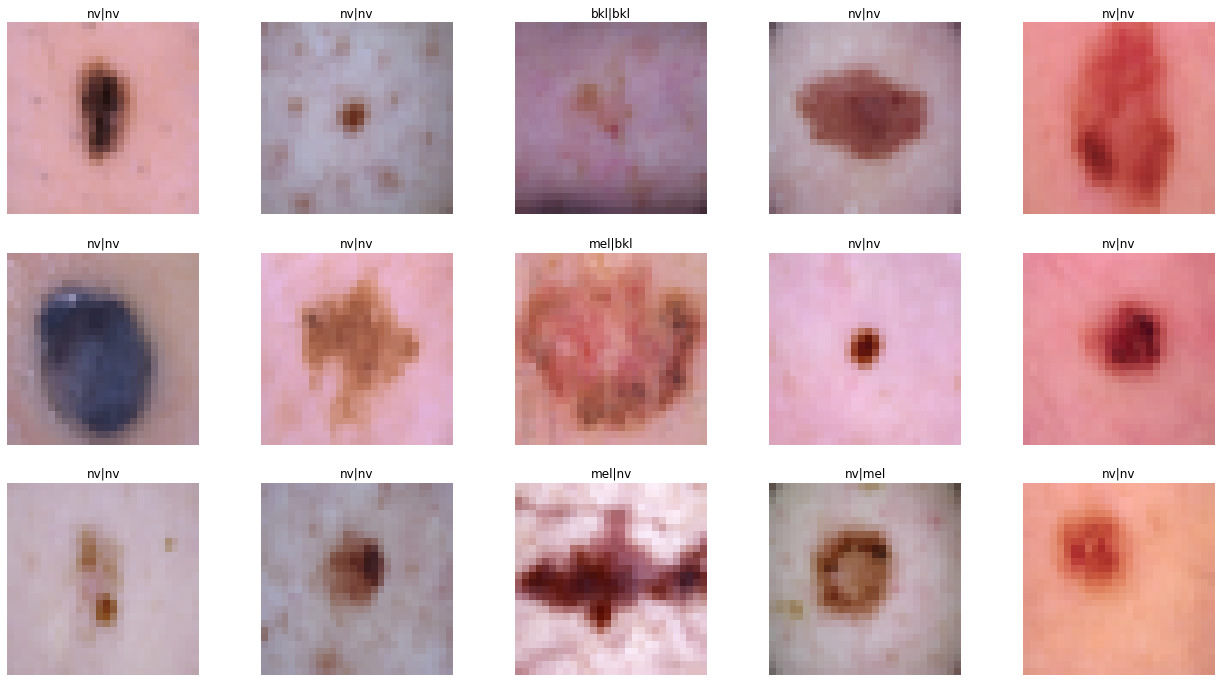

In [ ]:
test_model(model1,X_test_orig, Y_test_orig)

# Hyperparameter Tuning

In [ ]:
#Function for hyperparameter tuning(Finding out the best combinations for improved accuracy)
def model_hypertuning(X_train, Y_train, X_test, Y_test, param):
  dense1_neuron = int(param['dense1_neuron'])
  learning_rate = float(param['learning_rate'])
  model = Sequential()
  model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
  model.add(MaxPool2D(pool_size = (2,2)))

  model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
  model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

  model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
  model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    

  model.add(Flatten())
  model.add(Dense(dense1_neuron, activation = 'relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(7, activation='softmax'))

  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

  model.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = optimizer,
                metrics = ['accuracy'])
  early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                           mode='auto', restore_best_weights=True)
    
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')    
  history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = 25,
                        callbacks = [reduce_lr, early_stop])
  return history, model

In [ ]:
#parameters
param ={
    'dense1_neuron': [64, 128, 256],
    'activation': ['relu', 'elu'],
    'learning_rate':[0.001, 0.01]
}

In [ ]:
scan_results = ta.Scan(X_train_orig,Y_train_orig, params=param, model=model_hypertuning,experiment_name="Model_test")

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1/25
71/71 [==============================] - 1s 10ms/step - loss: 2.1556 - accuracy: 0.6204 - val_loss: 1.0259 - val_accuracy: 0.6560 - lr: 0.0010
Epoch 2/25
71/71 [==============================] - 0s 5ms/step - loss: 0.9407 - accuracy: 0.6781 - val_loss: 1.0201 - val_accuracy: 0.6488 - lr: 0.0010
Epoch 3/25
71/71 [==============================] - 0s 5ms/step - loss: 0.9016 - accuracy: 0.6881 - val_loss: 0.9176 - val_accuracy: 0.6738 - lr: 0.0010
Epoch 4/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8607 - accuracy: 0.7000 - val_loss: 0.9348 - val_accuracy: 0.6916 - lr: 0.0010
Epoch 5/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8478 - accuracy: 0.7013 - val_loss: 0.8572 - val_accuracy: 0.7041 - lr: 0.0010
Epoch 6/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8163 - accuracy: 0.7098 - val_loss: 0.8622 - val_accuracy: 0.6836 - lr: 0.0010
Epoch 7/25
71/71 [==============================] - 0s 5ms/step - loss: 0.7751 - 

  8%|▊         | 1/12 [00:09<01:49,  9.95s/it]

Epoch 1/25
71/71 [==============================] - 1s 8ms/step - loss: 2.3912 - accuracy: 0.5905 - val_loss: 1.1046 - val_accuracy: 0.6604 - lr: 0.0010
Epoch 2/25
71/71 [==============================] - 0s 5ms/step - loss: 0.9699 - accuracy: 0.6627 - val_loss: 0.9250 - val_accuracy: 0.6827 - lr: 0.0010
Epoch 3/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8959 - accuracy: 0.6799 - val_loss: 0.8779 - val_accuracy: 0.6943 - lr: 0.0010
Epoch 4/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8580 - accuracy: 0.6939 - val_loss: 0.9525 - val_accuracy: 0.6898 - lr: 0.0010
Epoch 5/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8367 - accuracy: 0.6979 - val_loss: 0.9153 - val_accuracy: 0.6658 - lr: 0.0010
Epoch 6/25
71/71 [==============================] - 0s 5ms/step - loss: 0.7961 - accuracy: 0.7162 - val_loss: 0.8460 - val_accuracy: 0.7237 - lr: 0.0010
Epoch 7/25
71/71 [==============================] - 0s 5ms/step - loss: 0.7682 - a

 17%|█▋        | 2/12 [00:20<01:45, 10.55s/it]

Epoch 1/25
71/71 [==============================] - 1s 7ms/step - loss: 2.0004 - accuracy: 0.6159 - val_loss: 1.0318 - val_accuracy: 0.6720 - lr: 0.0010
Epoch 2/25
71/71 [==============================] - 0s 5ms/step - loss: 0.9348 - accuracy: 0.6783 - val_loss: 0.9504 - val_accuracy: 0.6533 - lr: 0.0010
Epoch 3/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8830 - accuracy: 0.6915 - val_loss: 0.9406 - val_accuracy: 0.6845 - lr: 0.0010
Epoch 4/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8557 - accuracy: 0.7002 - val_loss: 0.9823 - val_accuracy: 0.6818 - lr: 0.0010
Epoch 5/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8257 - accuracy: 0.7033 - val_loss: 0.9300 - val_accuracy: 0.6889 - lr: 0.0010
Epoch 6/25
71/71 [==============================] - 0s 5ms/step - loss: 0.7987 - accuracy: 0.7171 - val_loss: 0.8670 - val_accuracy: 0.6934 - lr: 0.0010
Epoch 7/25
71/71 [==============================] - 0s 5ms/step - loss: 0.7980 - a

 25%|██▌       | 3/12 [00:29<01:26,  9.62s/it]

Epoch 1/25
71/71 [==============================] - 1s 7ms/step - loss: 2.2459 - accuracy: 0.6119 - val_loss: 1.0637 - val_accuracy: 0.5971 - lr: 0.0010
Epoch 2/25
71/71 [==============================] - 0s 5ms/step - loss: 0.9433 - accuracy: 0.6694 - val_loss: 0.9064 - val_accuracy: 0.6845 - lr: 0.0010
Epoch 3/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8991 - accuracy: 0.6857 - val_loss: 0.9270 - val_accuracy: 0.6898 - lr: 0.0010
Epoch 4/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8468 - accuracy: 0.7031 - val_loss: 0.8828 - val_accuracy: 0.6863 - lr: 0.0010
Epoch 5/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8101 - accuracy: 0.7078 - val_loss: 0.8541 - val_accuracy: 0.7023 - lr: 0.0010
Epoch 6/25
71/71 [==============================] - 0s 5ms/step - loss: 0.7845 - accuracy: 0.7169 - val_loss: 0.8832 - val_accuracy: 0.6934 - lr: 0.0010
Epoch 7/25
71/71 [==============================] - 0s 5ms/step - loss: 0.7527 - a

 33%|███▎      | 4/12 [00:38<01:14,  9.33s/it]

Epoch 1/25
71/71 [==============================] - 1s 7ms/step - loss: 2.4940 - accuracy: 0.6181 - val_loss: 1.0676 - val_accuracy: 0.6684 - lr: 0.0010
Epoch 2/25
71/71 [==============================] - 0s 5ms/step - loss: 0.9515 - accuracy: 0.6712 - val_loss: 0.9827 - val_accuracy: 0.6622 - lr: 0.0010
Epoch 3/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8881 - accuracy: 0.6830 - val_loss: 0.8893 - val_accuracy: 0.6827 - lr: 0.0010
Epoch 4/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8370 - accuracy: 0.6975 - val_loss: 0.9003 - val_accuracy: 0.6970 - lr: 0.0010
Epoch 5/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8139 - accuracy: 0.7124 - val_loss: 0.8981 - val_accuracy: 0.7077 - lr: 0.0010
Epoch 6/25
71/71 [==============================] - 0s 4ms/step - loss: 0.7603 - accuracy: 0.7240 - val_loss: 0.9098 - val_accuracy: 0.6720 - lr: 0.0010
Epoch 7/25
71/71 [==============================] - 0s 5ms/step - loss: 0.7736 - a

 42%|████▏     | 5/12 [00:47<01:04,  9.16s/it]

Epoch 1/25
71/71 [==============================] - 1s 7ms/step - loss: 2.9344 - accuracy: 0.6128 - val_loss: 0.9529 - val_accuracy: 0.6613 - lr: 0.0010
Epoch 2/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8906 - accuracy: 0.6844 - val_loss: 0.9024 - val_accuracy: 0.6863 - lr: 0.0010
Epoch 3/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8707 - accuracy: 0.6913 - val_loss: 0.8700 - val_accuracy: 0.6854 - lr: 0.0010
Epoch 4/25
71/71 [==============================] - 0s 5ms/step - loss: 0.7982 - accuracy: 0.7133 - val_loss: 0.8649 - val_accuracy: 0.6943 - lr: 0.0010
Epoch 5/25
71/71 [==============================] - 0s 5ms/step - loss: 0.7733 - accuracy: 0.7151 - val_loss: 0.8772 - val_accuracy: 0.6943 - lr: 0.0010
Epoch 6/25
71/71 [==============================] - 0s 5ms/step - loss: 0.7262 - accuracy: 0.7376 - val_loss: 0.8115 - val_accuracy: 0.7130 - lr: 0.0010
Epoch 7/25
71/71 [==============================] - 0s 5ms/step - loss: 0.7095 - a

 50%|█████     | 6/12 [00:56<00:55,  9.24s/it]

Epoch 1/25
71/71 [==============================] - 1s 7ms/step - loss: 4.4612 - accuracy: 0.5693 - val_loss: 1.1537 - val_accuracy: 0.6702 - lr: 0.0010
Epoch 2/25
71/71 [==============================] - 0s 5ms/step - loss: 0.9765 - accuracy: 0.6674 - val_loss: 1.0270 - val_accuracy: 0.6720 - lr: 0.0010
Epoch 3/25
71/71 [==============================] - 0s 5ms/step - loss: 0.9201 - accuracy: 0.6828 - val_loss: 0.9362 - val_accuracy: 0.6907 - lr: 0.0010
Epoch 4/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8965 - accuracy: 0.6835 - val_loss: 0.9576 - val_accuracy: 0.6827 - lr: 0.0010
Epoch 5/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8768 - accuracy: 0.6895 - val_loss: 0.9311 - val_accuracy: 0.6934 - lr: 0.0010
Epoch 6/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8336 - accuracy: 0.7035 - val_loss: 0.8851 - val_accuracy: 0.6854 - lr: 0.0010
Epoch 7/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8160 - a

 58%|█████▊    | 7/12 [01:07<00:48,  9.75s/it]

Epoch 1/25
71/71 [==============================] - 1s 7ms/step - loss: 2.7590 - accuracy: 0.4724 - val_loss: 1.2310 - val_accuracy: 0.6711 - lr: 0.0010
Epoch 2/25
71/71 [==============================] - 0s 5ms/step - loss: 1.1106 - accuracy: 0.6618 - val_loss: 1.0350 - val_accuracy: 0.6702 - lr: 0.0010
Epoch 3/25
71/71 [==============================] - 0s 5ms/step - loss: 0.9986 - accuracy: 0.6641 - val_loss: 0.9930 - val_accuracy: 0.6702 - lr: 0.0010
Epoch 4/25
71/71 [==============================] - 0s 5ms/step - loss: 0.9655 - accuracy: 0.6638 - val_loss: 0.9824 - val_accuracy: 0.6711 - lr: 0.0010
Epoch 5/25
71/71 [==============================] - 0s 5ms/step - loss: 0.9340 - accuracy: 0.6658 - val_loss: 0.9343 - val_accuracy: 0.6738 - lr: 0.0010
Epoch 6/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8932 - accuracy: 0.6743 - val_loss: 0.9250 - val_accuracy: 0.6702 - lr: 0.0010
Epoch 7/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8785 - a

 67%|██████▋   | 8/12 [01:17<00:38,  9.72s/it]

Epoch 1/25
71/71 [==============================] - 1s 7ms/step - loss: 4.6465 - accuracy: 0.5811 - val_loss: 1.1073 - val_accuracy: 0.6711 - lr: 0.0010
Epoch 2/25
71/71 [==============================] - 0s 5ms/step - loss: 0.9800 - accuracy: 0.6670 - val_loss: 1.1651 - val_accuracy: 0.6702 - lr: 0.0010
Epoch 3/25
71/71 [==============================] - 0s 5ms/step - loss: 0.9470 - accuracy: 0.6777 - val_loss: 0.9367 - val_accuracy: 0.6649 - lr: 0.0010
Epoch 4/25
71/71 [==============================] - 0s 5ms/step - loss: 0.9010 - accuracy: 0.6832 - val_loss: 0.9049 - val_accuracy: 0.6970 - lr: 0.0010
Epoch 5/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8862 - accuracy: 0.6906 - val_loss: 0.9315 - val_accuracy: 0.6800 - lr: 0.0010
Epoch 6/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8561 - accuracy: 0.6991 - val_loss: 0.8954 - val_accuracy: 0.6979 - lr: 0.0010
Epoch 7/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8393 - a

 75%|███████▌  | 9/12 [01:26<00:29,  9.68s/it]

Epoch 1/25
71/71 [==============================] - 1s 7ms/step - loss: 2.5665 - accuracy: 0.5985 - val_loss: 0.9803 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 2/25
71/71 [==============================] - 0s 5ms/step - loss: 0.9296 - accuracy: 0.6815 - val_loss: 0.9911 - val_accuracy: 0.6613 - lr: 0.0010
Epoch 3/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8789 - accuracy: 0.6855 - val_loss: 0.9053 - val_accuracy: 0.6881 - lr: 0.0010
Epoch 4/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8194 - accuracy: 0.7147 - val_loss: 0.8800 - val_accuracy: 0.7032 - lr: 0.0010
Epoch 5/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8004 - accuracy: 0.7122 - val_loss: 0.9202 - val_accuracy: 0.6898 - lr: 0.0010
Epoch 6/25
71/71 [==============================] - 0s 5ms/step - loss: 0.7650 - accuracy: 0.7245 - val_loss: 0.8778 - val_accuracy: 0.6836 - lr: 0.0010
Epoch 7/25
71/71 [==============================] - 0s 5ms/step - loss: 0.7524 - a

 83%|████████▎ | 10/12 [01:37<00:20, 10.03s/it]

Epoch 1/25
71/71 [==============================] - 1s 7ms/step - loss: 2.0849 - accuracy: 0.6378 - val_loss: 1.1693 - val_accuracy: 0.6702 - lr: 0.0010
Epoch 2/25
71/71 [==============================] - 0s 5ms/step - loss: 0.9381 - accuracy: 0.6754 - val_loss: 0.9276 - val_accuracy: 0.6756 - lr: 0.0010
Epoch 3/25
71/71 [==============================] - 0s 5ms/step - loss: 0.9074 - accuracy: 0.6904 - val_loss: 0.9146 - val_accuracy: 0.6863 - lr: 0.0010
Epoch 4/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8559 - accuracy: 0.6986 - val_loss: 0.9362 - val_accuracy: 0.6872 - lr: 0.0010
Epoch 5/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8252 - accuracy: 0.7060 - val_loss: 0.8709 - val_accuracy: 0.7014 - lr: 0.0010
Epoch 6/25
71/71 [==============================] - 0s 5ms/step - loss: 0.7862 - accuracy: 0.7182 - val_loss: 0.8652 - val_accuracy: 0.7041 - lr: 0.0010
Epoch 7/25
71/71 [==============================] - 0s 5ms/step - loss: 0.7536 - a

 92%|█████████▏| 11/12 [01:48<00:10, 10.27s/it]

Epoch 1/25
71/71 [==============================] - 1s 7ms/step - loss: 2.9343 - accuracy: 0.6262 - val_loss: 1.0555 - val_accuracy: 0.6373 - lr: 0.0010
Epoch 2/25
71/71 [==============================] - 0s 5ms/step - loss: 0.9310 - accuracy: 0.6701 - val_loss: 0.9026 - val_accuracy: 0.6970 - lr: 0.0010
Epoch 3/25
71/71 [==============================] - 0s 5ms/step - loss: 0.8538 - accuracy: 0.7008 - val_loss: 0.8805 - val_accuracy: 0.6702 - lr: 0.0010
Epoch 4/25
71/71 [==============================] - 0s 5ms/step - loss: 0.7892 - accuracy: 0.7167 - val_loss: 0.8375 - val_accuracy: 0.7130 - lr: 0.0010
Epoch 5/25
71/71 [==============================] - 0s 5ms/step - loss: 0.7656 - accuracy: 0.7209 - val_loss: 0.8663 - val_accuracy: 0.6916 - lr: 0.0010
Epoch 6/25
71/71 [==============================] - 0s 5ms/step - loss: 0.7170 - accuracy: 0.7452 - val_loss: 0.8120 - val_accuracy: 0.7201 - lr: 0.0010
Epoch 7/25
71/71 [==============================] - 0s 5ms/step - loss: 0.6747 - a

100%|██████████| 12/12 [01:59<00:00,  9.92s/it]
